# Model Serving & Testing

This notebook loads the best model from MLflow and tests it on the test set.

## Overview
- **Load Model**: Load the best LightGBM model from MLflow registry
- **Test Evaluation**: Evaluate the model on the test set with comprehensive metrics
- **Performance Analysis**: Detailed analysis of model performance

## Metrics Evaluated
1. **AUC-ROC**: Area Under the ROC Curve
2. **Accuracy**: Overall classification accuracy
3. **Precision**: Precision score
4. **Recall**: Recall score
5. **F1-Score**: F1 score
6. **Business Cost**: Custom business cost (10×FN + 1×FP)
7. **Optimal Threshold**: Threshold that minimizes business cost


## 1. Setup and Configuration


In [1]:
import sys
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve
)
import mlflow
import mlflow.lightgbm
import mlflow.sklearn
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Project utilities
from src.utils.notebook_mlflow import (
    quick_mlflow_setup, NotebookMLFlow,
    FN_COST, FP_COST,
    calculate_business_cost, find_optimal_threshold
)
from src.utils.feature_io import load_data_splits

# Configuration
RANDOM_STATE = 42
MODEL_NAME = "LightGBM_best"  # Name of the registered model in MLflow

print("✅ Imports complete")
print(f"   Model Name: {MODEL_NAME}")
print(f"   Business Cost: {FN_COST}×FN + {FP_COST}×FP")


✅ Imports complete
   Model Name: LightGBM_best
   Business Cost: 10.0×FN + 1.0×FP


In [2]:
# Initialize MLflow
mlflow_tracker = quick_mlflow_setup("credit-scoring-lightgbm")
print("✅ MLflow tracker ready")


2026/01/09 16:18:59 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/09 16:18:59 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


✅ MLFlow configuré - Expérience: credit-scoring-lightgbm
✅ MLflow tracker ready


## 2. Load Data Splits


In [3]:
# Load pre-created data splits
splits = load_data_splits(input_dir="../data/processed")

X_train = splits["X_train"]
y_train = splits["y_train"]
X_val = splits["X_val"]
y_val = splits["y_val"]
X_test = splits["X_test"]
y_test = splits["y_test"]
feature_names = splits["feature_names"]

print(f"\n✅ Loaded data splits from: ../data/processed/data_splits.pkl")
print(f"   Train: {len(X_train):,} samples")
print(f"   Val:   {len(X_val):,} samples")
print(f"   Test:  {len(X_test):,} samples")
print(f"\n   Training set: {len(X_train):,} samples ({y_train.mean():.2%} positive)")
print(f"   Validation set: {len(X_val):,} samples ({y_val.mean():.2%} positive)")
print(f"   Test set: {len(X_test):,} samples ({y_test.mean():.2%} positive)")
print(f"   Number of features: {len(feature_names)}")


✅ Loaded data splits from: ../data/processed/data_splits.pkl
   Train: 184,503 samples
   Val:   61,502 samples
   Test:  61,502 samples

✅ Loaded data splits from: ../data/processed/data_splits.pkl
   Train: 184,503 samples
   Val:   61,502 samples
   Test:  61,502 samples

   Training set: 184,503 samples (8.07% positive)
   Validation set: 61,502 samples (8.07% positive)
   Test set: 61,502 samples (8.07% positive)
   Number of features: 763


## 3. Load Model from MLflow


In [4]:
# Method 1: Load from MLflow Registry (Production version)
print("\n" + "="*60)
print("LOADING MODEL FROM MLFLOW REGISTRY")
print("="*60)

try:
    client = mlflow.tracking.MlflowClient()
    
    # Get the latest version of the registered model
    model_versions = client.get_latest_versions(MODEL_NAME, stages=["None", "Staging", "Production"])
    
    if model_versions:
        latest_version = model_versions[0]
        model_uri = f"models:/{MODEL_NAME}/{latest_version.version}"
        print(f"\n✅ Found model in registry:")
        print(f"   Model: {MODEL_NAME}")
        print(f"   Version: {latest_version.version}")
        print(f"   Stage: {latest_version.current_stage}")
        print(f"   URI: {model_uri}")
    else:
        # Fallback: Search for the best run in the experiment
        print(f"\n⚠️  Model not found in registry. Searching for best run...")
        experiment = mlflow.get_experiment_by_name("credit-scoring-lightgbm")
        if experiment:
            runs = client.search_runs(
                experiment_ids=[experiment.experiment_id],
                filter_string="tags.best_model = 'true' AND tags.model_type = 'LightGBM'",
                order_by=["metrics.cv_auc_mean DESC"],
                max_results=1
            )
            if runs:
                best_run = runs[0]
                model_uri = f"runs:/{best_run.info.run_id}/model"
                print(f"\n✅ Found best run:")
                print(f"   Run ID: {best_run.info.run_id}")
                print(f"   URI: {model_uri}")
            else:
                raise ValueError("No best model found in MLflow")
        else:
            raise ValueError("Experiment 'credit-scoring-lightgbm' not found")
    
    # Load the model - Try different MLflow flavors
    print(f"\n📦 Loading model from MLflow...")
    try:
        # Try LightGBM flavor first
        model = mlflow.lightgbm.load_model(model_uri)
        print(f"✅ Model loaded successfully with LightGBM flavor!")
        print(f"   Model type: {type(model).__name__}")
    except Exception as e1:
        print(f"⚠️  LightGBM flavor not available: {e1}")
        try:
            # Fallback: Try sklearn flavor (for models registered before the fix)
            print(f"📦 Attempting to load with sklearn flavor...")
            model = mlflow.sklearn.load_model(model_uri)
            print(f"✅ Model loaded successfully with sklearn flavor!")
            print(f"   Model type: {type(model).__name__}")
            print(f"   ⚠️  Note: Model was registered with sklearn flavor. Consider re-registering with LightGBM flavor.")
        except Exception as e2:
            print(f"\n❌ Error loading from MLflow with both flavors:")
            print(f"   LightGBM: {e1}")
            print(f"   Sklearn: {e2}")
            print(f"\n📦 Attempting to load from local file...")
            
            # Final fallback: Load from local pickle file
            model_path = Path("../src/models/lgbm_best_model.pkl")
            if model_path.exists():
                with open(model_path, 'rb') as f:
                    model = pickle.load(f)
                print(f"✅ Model loaded from local file: {model_path}")
                print(f"   Model type: {type(model).__name__}")
            else:
                raise FileNotFoundError(f"Model file not found: {model_path}")
    
except Exception as e:
    print(f"\n❌ Error accessing MLflow: {e}")
    print(f"\n📦 Attempting to load from local file...")
    
    # Fallback: Load from local pickle file
    model_path = Path("../src/models/lgbm_best_model.pkl")
    if model_path.exists():
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"✅ Model loaded from local file: {model_path}")
        print(f"   Model type: {type(model).__name__}")
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")


2026/01/09 16:19:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/09 16:19:19 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.



LOADING MODEL FROM MLFLOW REGISTRY

✅ Found model in registry:
   Model: LightGBM_best
   Version: 3
   Stage: None
   URI: models:/LightGBM_best/3

📦 Loading model from MLflow...
✅ Model loaded successfully with LightGBM flavor!
   Model type: LGBMClassifier


In [5]:
model

,boosting_type,'gbdt'
,num_leaves,41
,max_depth,8
,learning_rate,0.023494051357506786
,n_estimators,462
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,57


In [6]:
# Make predictions on test set
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

print(f"\n📊 Making predictions on test set ({len(X_test):,} samples)...")
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

print("✅ Predictions completed")
print(f"   Prediction shape: {y_test_pred_proba.shape}")
print(f"   Min probability: {y_test_pred_proba.min():.4f}")
print(f"   Max probability: {y_test_pred_proba.max():.4f}")
print(f"   Mean probability: {y_test_pred_proba.mean():.4f}")



TEST SET EVALUATION

📊 Making predictions on test set (61,502 samples)...
✅ Predictions completed
   Prediction shape: (61502,)
   Min probability: 0.0147
   Max probability: 0.9480
   Mean probability: 0.3682


In [7]:
# Find optimal threshold (using validation set to determine threshold)
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

# Get predictions on validation set to find optimal threshold
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
optimal_threshold, optimal_cost_val = find_optimal_threshold(y_val, y_val_pred_proba)

print(f"\n📊 Optimal threshold (from validation set): {optimal_threshold:.4f}")
print(f"   Validation cost with optimal threshold: {optimal_cost_val:.1f}")

# Apply optimal threshold to test set
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

# Also calculate with default threshold (0.5) for comparison
y_test_pred_default = (y_test_pred_proba >= 0.5).astype(int)

print(f"\n✅ Threshold applied to test set")



THRESHOLD OPTIMIZATION

📊 Optimal threshold (from validation set): 0.4949
   Validation cost with optimal threshold: 30035.0

✅ Threshold applied to test set


In [8]:
# Calculate all metrics
print("\n" + "="*60)
print("TEST SET METRICS")
print("="*60)

# Metrics with optimal threshold
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_cost = calculate_business_cost(y_test, y_test_pred)

# Metrics with default threshold (0.5)
test_accuracy_default = accuracy_score(y_test, y_test_pred_default)
test_precision_default = precision_score(y_test, y_test_pred_default, zero_division=0)
test_recall_default = recall_score(y_test, y_test_pred_default, zero_division=0)
test_f1_default = f1_score(y_test, y_test_pred_default, zero_division=0)
test_cost_default = calculate_business_cost(y_test, y_test_pred_default)

# Confusion matrices
cm_optimal = confusion_matrix(y_test, y_test_pred)
cm_default = confusion_matrix(y_test, y_test_pred_default)
tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
tn_def, fp_def, fn_def, tp_def = cm_default.ravel()

print(f"\n📊 Metrics with Optimal Threshold ({optimal_threshold:.4f}):")
print(f"   AUC-ROC:        {test_auc:.4f}")
print(f"   Accuracy:       {test_accuracy:.4f}")
print(f"   Precision:      {test_precision:.4f}")
print(f"   Recall:         {test_recall:.4f}")
print(f"   F1-Score:       {test_f1:.4f}")
print(f"   Business Cost:  {test_cost:.1f} (10×{fn_opt} + 1×{fp_opt} = {10*fn_opt + fp_opt})")

print(f"\n📊 Metrics with Default Threshold (0.5000):")
print(f"   Accuracy:       {test_accuracy_default:.4f}")
print(f"   Precision:      {test_precision_default:.4f}")
print(f"   Recall:         {test_recall_default:.4f}")
print(f"   F1-Score:       {test_f1_default:.4f}")
print(f"   Business Cost:  {test_cost_default:.1f} (10×{fn_def} + 1×{fp_def} = {10*fn_def + fp_def})")

print(f"\n📊 Confusion Matrix (Optimal Threshold):")
print(f"   True Negatives:  {tn_opt:,}")
print(f"   False Positives: {fp_opt:,}")
print(f"   False Negatives: {fn_opt:,}")
print(f"   True Positives:  {tp_opt:,}")

print(f"\n📊 Confusion Matrix (Default Threshold):")
print(f"   True Negatives:  {tn_def:,}")
print(f"   False Positives: {fp_def:,}")
print(f"   False Negatives: {fn_def:,}")
print(f"   True Positives:  {tp_def:,}")



TEST SET METRICS

📊 Metrics with Optimal Threshold (0.4949):
   AUC-ROC:        0.7860
   Accuracy:       0.7425
   Precision:      0.1921
   Recall:         0.6830
   F1-Score:       0.2998
   Business Cost:  30002.0 (10×1574 + 1×14262 = 30002)

📊 Metrics with Default Threshold (0.5000):
   Accuracy:       0.7477
   Precision:      0.1945
   Recall:         0.6769
   F1-Score:       0.3022
   Business Cost:  29955.0 (10×1604 + 1×13915 = 29955)

📊 Confusion Matrix (Optimal Threshold):
   True Negatives:  42,275
   False Positives: 14,262
   False Negatives: 1,574
   True Positives:  3,391

📊 Confusion Matrix (Default Threshold):
   True Negatives:  42,622
   False Positives: 13,915
   False Negatives: 1,604
   True Positives:  3,361


## 5. Visualizations


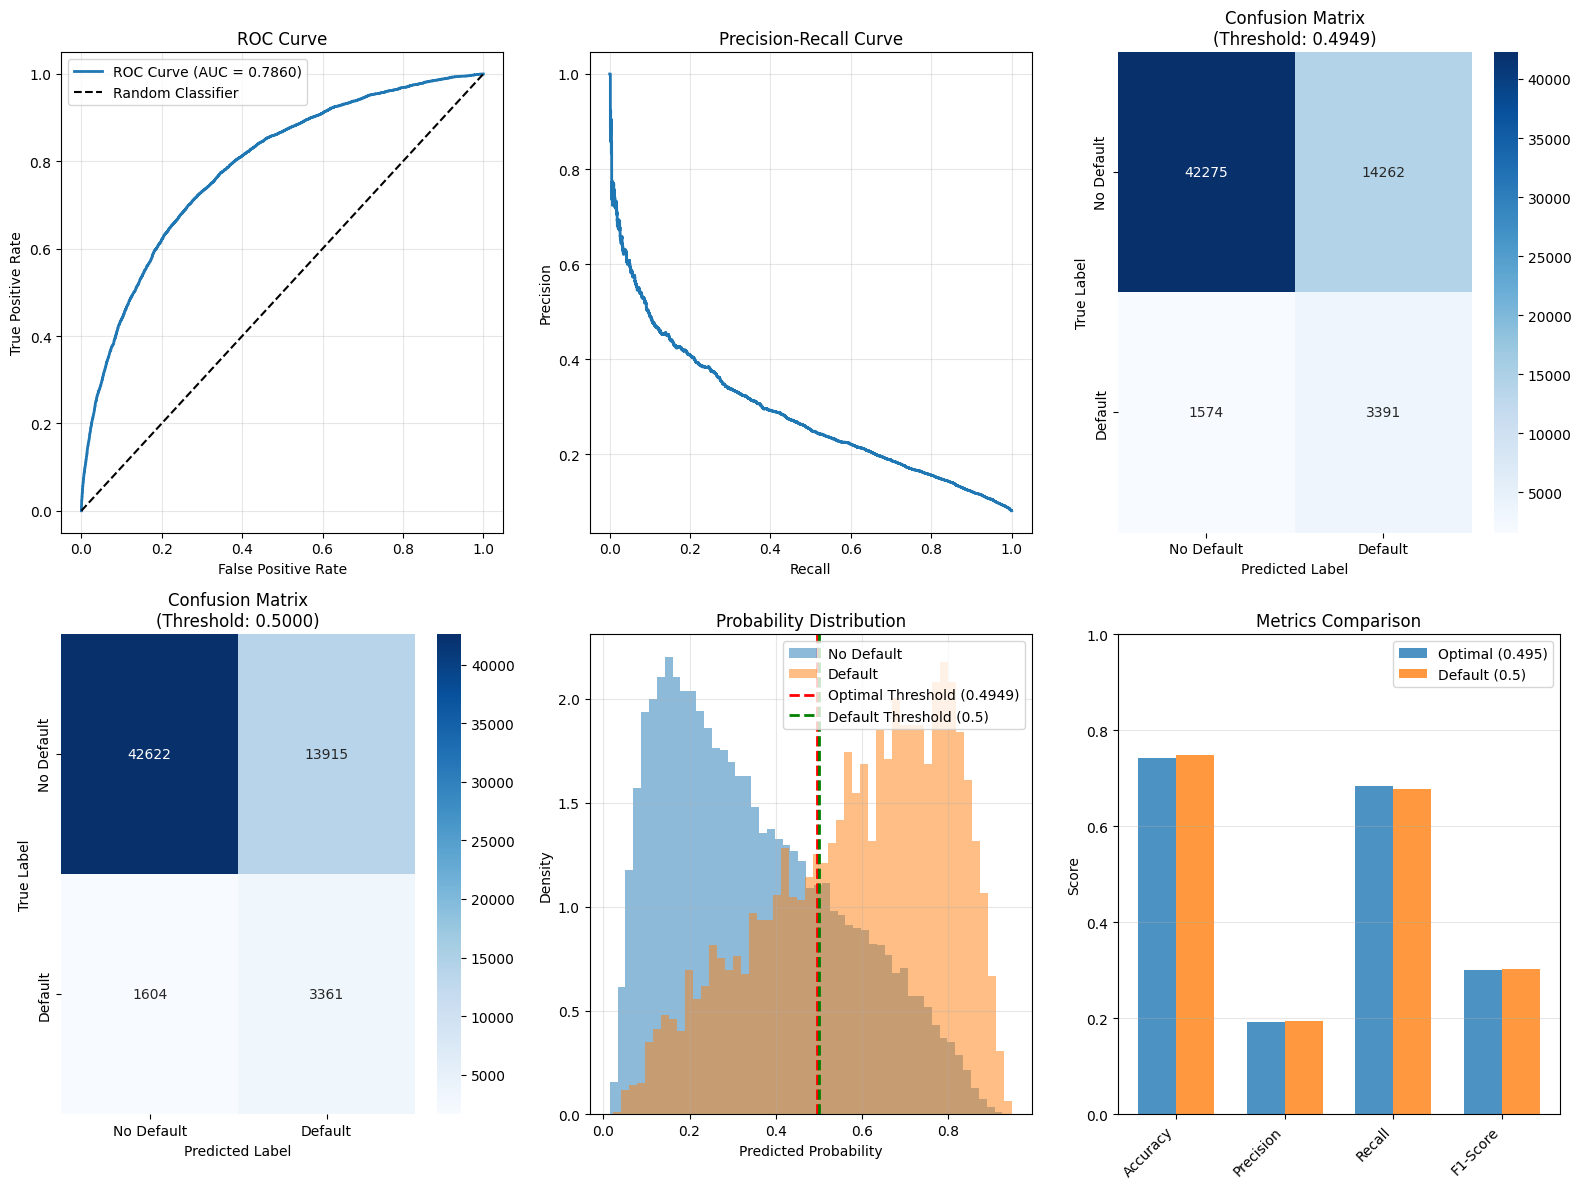


✅ Visualizations saved to: ../data/processed/model_test_results.png


In [9]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. ROC Curve
ax1 = plt.subplot(2, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
ax2 = plt.subplot(2, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
ax2.plot(recall, precision, linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix (Optimal Threshold)
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
ax3.set_title(f'Confusion Matrix\n(Threshold: {optimal_threshold:.4f})')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# 4. Confusion Matrix (Default Threshold)
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
ax4.set_title('Confusion Matrix\n(Threshold: 0.5000)')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

# 5. Probability Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_test_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Default', density=True)
ax5.hist(y_test_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Default', density=True)
ax5.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.4f})')
ax5.axvline(0.5, color='green', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Density')
ax5.set_title('Probability Distribution')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
optimal_values = [test_accuracy, test_precision, test_recall, test_f1]
default_values = [test_accuracy_default, test_precision_default, test_recall_default, test_f1_default]
x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, optimal_values, width, label=f'Optimal ({optimal_threshold:.3f})', alpha=0.8)
ax6.bar(x + width/2, default_values, width, label='Default (0.5)', alpha=0.8)
ax6.set_ylabel('Score')
ax6.set_title('Metrics Comparison')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../data/processed/model_test_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved to: ../data/processed/model_test_results.png")


## 6. Business Cost Analysis



BUSINESS COST ANALYSIS


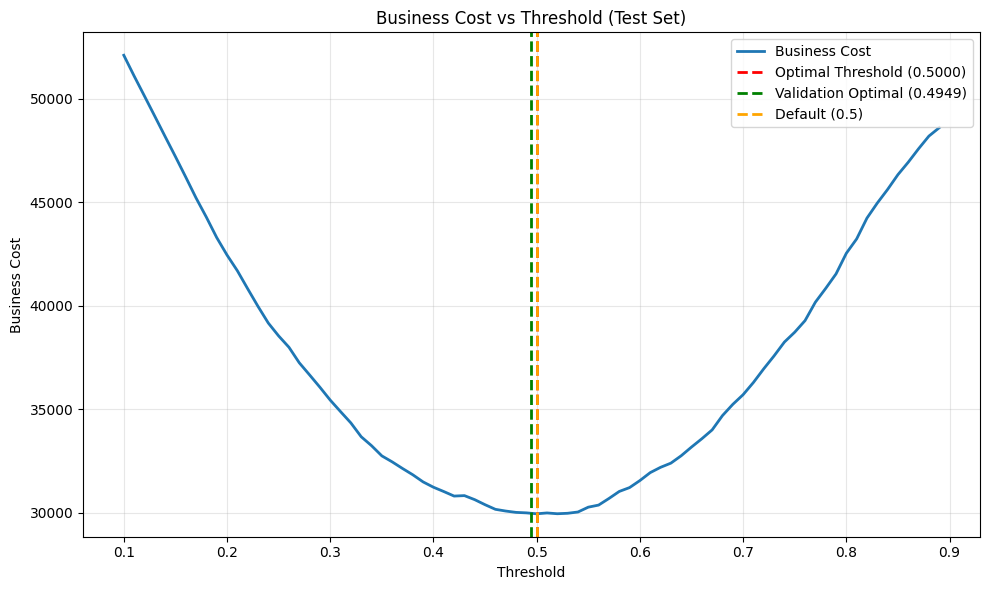


📊 Optimal threshold on test set: 0.5000
   Optimal cost on test set: 29955.0
   Cost with validation threshold (0.4949): 30002.0
   Cost with default threshold (0.5): 29955.0

✅ Business cost analysis saved to: ../data/processed/business_cost_analysis.png


In [10]:
# Business cost vs threshold analysis
print("\n" + "="*60)
print("BUSINESS COST ANALYSIS")
print("="*60)

# Calculate cost for different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for threshold in thresholds:
    y_pred_thresh = (y_test_pred_proba >= threshold).astype(int)
    cost = calculate_business_cost(y_test, y_pred_thresh)
    costs.append(cost)

costs = np.array(costs)
optimal_idx = np.argmin(costs)
optimal_threshold_test = thresholds[optimal_idx]
optimal_cost_test = costs[optimal_idx]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, costs, linewidth=2, label='Business Cost')
ax.axvline(optimal_threshold_test, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal Threshold ({optimal_threshold_test:.4f})')
ax.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2,
           label=f'Validation Optimal ({optimal_threshold:.4f})')
ax.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Default (0.5)')
ax.set_xlabel('Threshold')
ax.set_ylabel('Business Cost')
ax.set_title('Business Cost vs Threshold (Test Set)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/business_cost_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Optimal threshold on test set: {optimal_threshold_test:.4f}")
print(f"   Optimal cost on test set: {optimal_cost_test:.1f}")
print(f"   Cost with validation threshold ({optimal_threshold:.4f}): {test_cost:.1f}")
print(f"   Cost with default threshold (0.5): {test_cost_default:.1f}")
print(f"\n✅ Business cost analysis saved to: ../data/processed/business_cost_analysis.png")


## 7. Summary and Model Information


In [11]:
# Final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📦 Model Information:")
print(f"   Model Type: {type(model).__name__}")
print(f"   Model Name: {MODEL_NAME}")
print(f"   Number of Features: {X_test.shape[1]}")
print(f"   Test Set Size: {len(X_test):,} samples")

print(f"\n📊 Test Set Performance (Optimal Threshold: {optimal_threshold:.4f}):")
print(f"   AUC-ROC:       {test_auc:.4f}")
print(f"   Accuracy:      {test_accuracy:.4f}")
print(f"   Precision:     {test_precision:.4f}")
print(f"   Recall:        {test_recall:.4f}")
print(f"   F1-Score:      {test_f1:.4f}")
print(f"   Business Cost: {test_cost:.1f}")

print(f"\n📊 Confusion Matrix:")
print(f"   TN: {tn_opt:,}  |  FP: {fp_opt:,}")
print(f"   FN: {fn_opt:,}  |  TP: {tp_opt:,}")

print(f"\n✅ Model testing completed successfully!")
print(f"   The model is ready for deployment.")



FINAL SUMMARY

📦 Model Information:
   Model Type: LGBMClassifier
   Model Name: LightGBM_best
   Number of Features: 763
   Test Set Size: 61,502 samples

📊 Test Set Performance (Optimal Threshold: 0.4949):
   AUC-ROC:       0.7860
   Accuracy:      0.7425
   Precision:     0.1921
   Recall:        0.6830
   F1-Score:      0.2998
   Business Cost: 30002.0

📊 Confusion Matrix:
   TN: 42,275  |  FP: 14,262
   FN: 1,574  |  TP: 3,391

✅ Model testing completed successfully!
   The model is ready for deployment.


In [12]:
# Save test results
test_results = {
    "model_name": MODEL_NAME,
    "model_type": type(model).__name__,
    "optimal_threshold": optimal_threshold,
    "test_metrics": {
        "auc": test_auc,
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "f1_score": test_f1,
        "business_cost": test_cost
    },
    "confusion_matrix": {
        "tn": int(tn_opt),
        "fp": int(fp_opt),
        "fn": int(fn_opt),
        "tp": int(tp_opt)
    },
    "n_test_samples": len(X_test),
    "n_features": X_test.shape[1]
}

results_path = Path("../data/processed/model_test_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(test_results, f)

print(f"\n✅ Test results saved to: {results_path}")



✅ Test results saved to: ../data/processed/model_test_results.pkl
